# Homework 2 - Unsupervised Deep Learning

---
A.A. 2021/22, Borella Lorenzo, mat. 2012266
---

The following cells have all been ran on Google Colab. By exploiting the presence of a GPU I was able to increase the computational efficiency of the most demanding training cells and reduce their runtime.

In [ ]:
#run on colab
! pip install optuna

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from optuna.visualization import plot_optimization_history, plot_parallel_coordinate
from optuna.visualization import plot_param_importances, plot_slice

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
from torchvision import transforms
import torchvision.utils as vutils
import torchvision

import optuna

In [3]:
#set seed
seed = 3
random.seed(seed)
torch.manual_seed(seed)

#Select device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

# 1) Preprocessing

## 1.1) Datasets and Dataloaders


I defined the Train, Validation and Test sets as in the previous homework. I first downloaded the $\texttt{torchvision.dataset}$ objects, splitted the training and validation sets respectively as 75% and 25% of the original training data and moved all of them into Dataloader format.

The batch size for the Training Dataloader has been set as 1000, while Validation and Test sets are considered as a sigle batch by setting their batch size equal to their lengths. The number of workers in each Dataloader has been set to 4, in order to exploit parallel processes computation in the GPU. For the Training and Validation sets, the shuffle flag has been set as $\texttt{TRUE}$ to improve randomization.

Eventually I plotted the dimension of the different sets of data, as well as the number of the different classes and some examples of the objects we are dealing with.

In [39]:
#define transformations to apply to datasets
dataset_transforms = transforms.Compose([transforms.ToTensor()])

###DATASETS
train_dataset = torchvision.datasets.FashionMNIST('data', train=True, 
                                                  transform=dataset_transforms, download=True)
test_dataset  = torchvision.datasets.FashionMNIST('data', train=False, 
                                                  transform=dataset_transforms, download=True)

#different classes
label_names=['t-shirt','trouser','pullover','dress','coat','sandal','shirt',
             'sneaker','bag','boot']
n_classes = len(label_names)
print("Number of Different Classes:",n_classes)

#define training, validation and test dimensions
train_percentage = 0.75
train_dim = int(train_percentage*len(train_dataset))
val_dim = int(len(train_dataset) - train_dim)
test_dim = len(test_dataset)

#split training and validation data
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_dim, val_dim])
print("Dimension of Training Set:",train_dim,"\nDimension of Validation Set:", val_dim,
      "\nDimension of Test Set:",test_dim)

###DATALOADERS
batch_size=1000
train_dataloader = DataLoader(train_dataset, batch_size, num_workers=4,shuffle=True)
val_dataloader = DataLoader(val_dataset, len(val_dataset), num_workers=4, shuffle=True)
test_dataloader = DataLoader(test_dataset, len(test_dataset), num_workers=4,shuffle=False)

Number of Different Classes: 10
Dimension of Training Set: 45000 
Dimension of Validation Set: 15000 
Dimension of Test Set: 10000


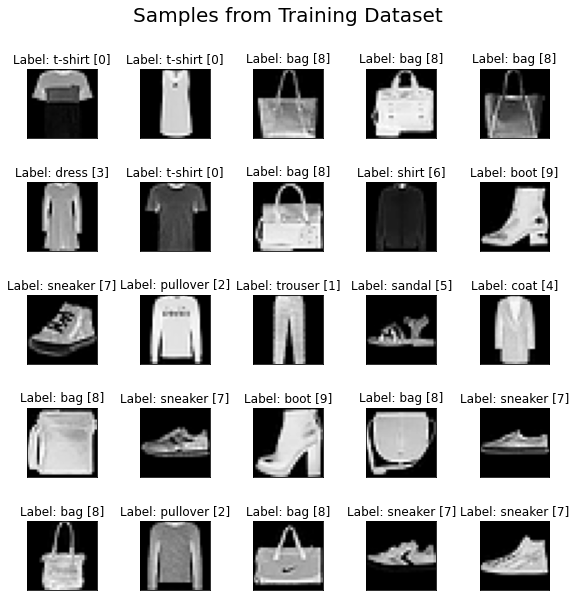

In [ ]:
##PLOT SOME EXAMPLES
fig, axs = plt.subplots(5, 5, figsize=(8,8))

for ax in axs.flatten():
    
    #select random sample
    img, label = random.choice(train_dataset)
    img = img.squeeze(0)
    
    #show
    ax.imshow(np.array(img), cmap='gist_gray')
    ax.set_title(f'Label: {label_names[label]} [{label}]')
    ax.set_xticks([])
    ax.set_yticks([])
plt.suptitle("Samples from Training Dataset",fontsize=20,x=0.5,y=1.05)    
plt.tight_layout()

## 1.2) Data Distribution

I studied the data distribution in each set of data, as in the previous homework. As we can see from the below plots, the distribution of the classes in the Train and Validation sets depends on the randomization and splitting of the dataloaders objects, while the Test set presents always the same quantity of samples per each class.

In [ ]:
#for each class
count_train = []
count_val = []
count_test = []
for index, class_name in enumerate(label_names): 

    #TRAIN DATALOADER
    index_tensor = torch.tensor(np.repeat(index,batch_size))
    count = 0
    for batch in train_dataloader:
        #list of labels
        label_batch = batch[1]
        count = count + torch.sum(label_batch==index_tensor)
    count_train.append(count)

    #VAL DATALOADER
    index_tensor = torch.tensor(np.repeat(index,val_dim))
    count = 0
    for batch in val_dataloader:
        #list of labels
        label_batch = batch[1]
        count = count + torch.sum(label_batch==index_tensor)
    count_val.append(count)

    #TEST DATALOADER
    index_tensor = torch.tensor(np.repeat(index,10000))
    count = 0
    for batch in test_dataloader:
        #list of labels
        label_batch = batch[1]
        count = count + torch.sum(label_batch==index_tensor)
    count_test.append(count)

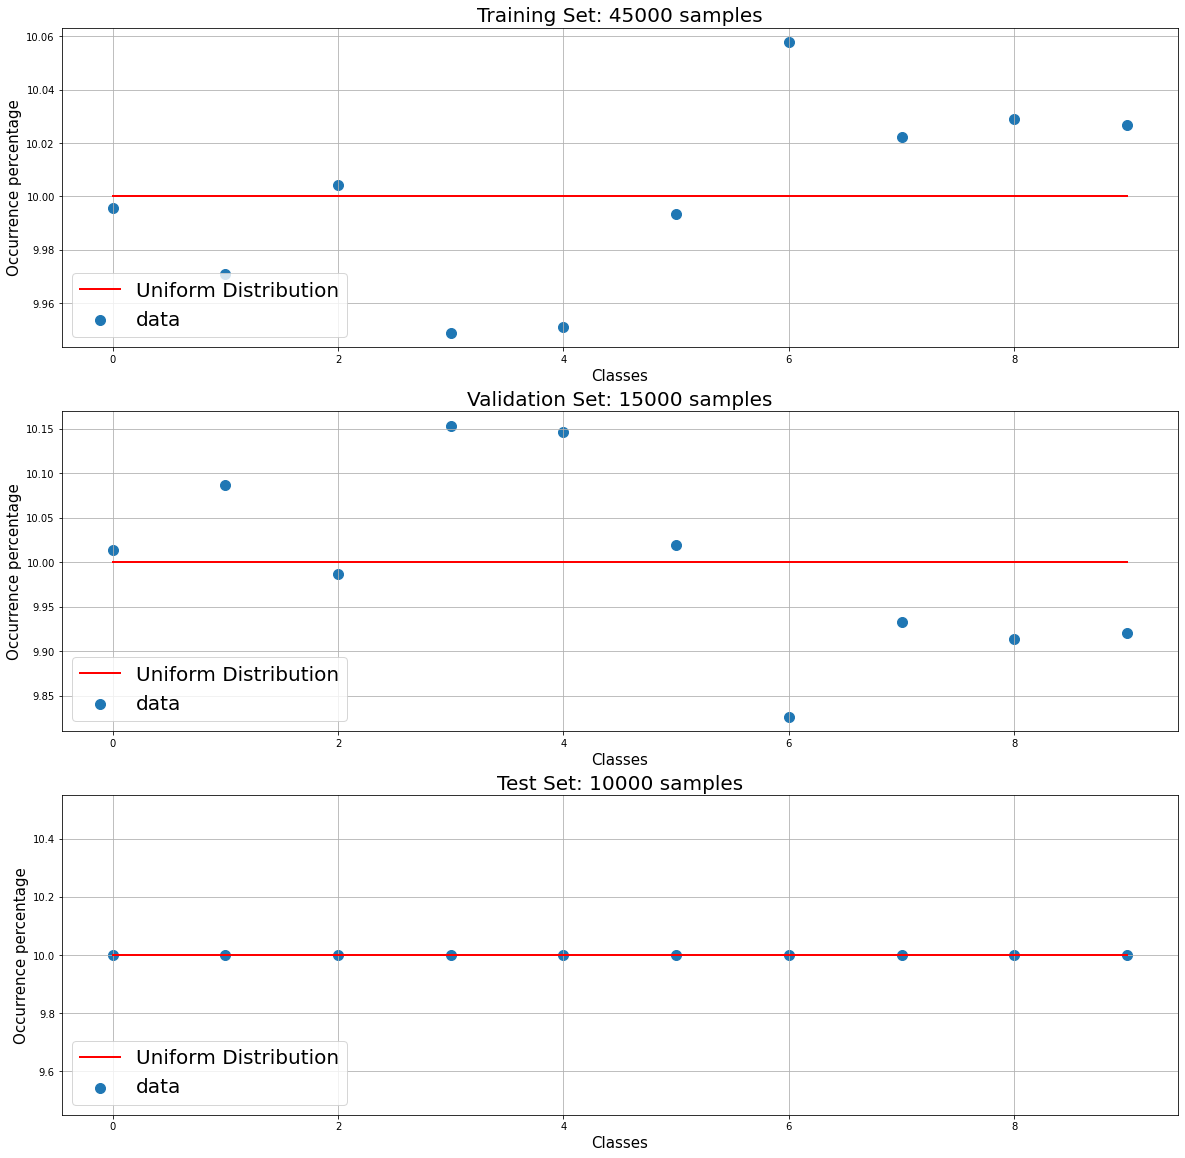

In [ ]:
#plot distribution of datasets
fig,ax = plt.subplots(3,1,figsize=(20,20))
sets = ['Training Set','Validation Set','Test Set']
dims = [train_dim,val_dim,test_dim]
counts = [count_train,count_val,count_test]

for i,s in enumerate(sets):

    #normalize
    count = counts[i]/np.sum(counts[i])

    ax[i].scatter(np.arange(0,10),count*100,s=100,label="data")
    ax[i].set_title(f"{s}: {dims[i]} samples",fontsize=20)
    ax[i].plot(np.arange(0,10),np.repeat(10,10),color='red',linewidth=2,label="Uniform Distribution")
    ax[i].set_xlabel("Classes",fontsize=15)
    ax[i].set_ylabel("Occurrence percentage",fontsize=15)
    ax[i].grid()
    ax[i].legend(fontsize=20,loc="lower left")

plt.show()


# 2) Convolutional Autoencoder

## 2.1) Classes and function definitions.

The followiing is the definition of the Encoder class that will be used in the following to build the Convolutional Autoencoder.

I defined it starting from the CNN architecture exploited in the previous notebook for the Classification task. It has three convolutional layers with variable number of channels and two linear layeers with variable number of neurons.

The encoder is the entity that maps an input 28x28 image into the latent space, therefore the number of input channels is set to be 1, while the latent space dimension is left as a variable parameter that will be optimized innthe following through Optuna. 

For simplicity I decided to keep fixed the $\texttt{stride=1}$ and $\texttt{padding=0}$ parameters while the $\texttt{kernel_size}$ is left variable . The stride describes the pace used by the kernel filters to scan the input image, while the padding refers to the choice of adding a contour of 0 values around the input image. From what I have learned from the previous notebook, these parameters do not present a huge importance in the learning process, therefore I decided to keep them fixed.

In [5]:
class Encoder(nn.Module):
    
    def __init__(self, params_dict):
        super().__init__()
        
        #read parameters from dictionary
        cl_out1 = params_dict["cl_out1"]
        cl_out2 = params_dict["cl_out2"]
        cl_out3 = params_dict["cl_out3"]
        encoded_space_dim = params_dict["encoded_space_dim"]
        kernel_size = params_dict["kernel_size"]
        
        ### Convolutional section
        self.conv_encoder = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(in_channels=1, out_channels=cl_out1, kernel_size=kernel_size, 
                      stride=1, padding=0),nn.ReLU(True),
            # Second convolutional layer
            nn.Conv2d(in_channels=cl_out1, out_channels=cl_out2, kernel_size=kernel_size, 
                      stride=1, padding=0),nn.ReLU(True),
            # Third convolutional layer
            nn.Conv2d(in_channels=cl_out2, out_channels=cl_out3, kernel_size=kernel_size, 
                      stride=1, padding=0),nn.ReLU(True)
        )
        
        #keep track of dimensions
        first_linear, second_linear = linear_dim(3, cl_out3, kernel_size,padding=0,stride=1)
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1) 
        
        ### Linear section
        self.lin_encoder = nn.Sequential(
            # First linear layer
            nn.Linear(in_features=first_linear, out_features=second_linear),nn.ReLU(True),
            # Second linear layer
            nn.Linear(in_features=second_linear, out_features=encoded_space_dim)
        )
        
    def forward(self, x):
        x = self.conv_encoder(x)
        x = self.flatten(x)
        x = self.lin_encoder(x)
        return x


The Decoder class has been built in a symmetric way with respect to the Encoder class. It reconstructs the sampled images from the values in the latent space to a 28x28 image in output.

It has the same structure as the Encoder, but transposed. The latent space values are taken as an input and processed through two linear layers with variable number of neurons. After having reshaped the output values of the linear layers, three transposed convolutional layers are processing the data in order to be able to reconstruct a 28x28 image as final output.

The last step of the architecture applies the sigmoid function in order to assure output values in the range $[0,1]$, as required from the greyscale image definition.

In [6]:
class Decoder(nn.Module):
    
    def __init__(self, params_dict):
        super().__init__()
        
        #read parameters from dictionary
        cl_out1 = params_dict["cl_out1"]
        cl_out2 = params_dict["cl_out2"]
        cl_out3 = params_dict["cl_out3"]
        first_linear = params_dict["first_linear"]
        second_linear = params_dict["second_linear"]
        encoded_space_dim = params_dict["encoded_space_dim"]
        kernel_size = params_dict["kernel_size"]

        ### Linear section
        self.lin_decoder = nn.Sequential(
            # First linear layer
            nn.Linear(in_features=encoded_space_dim, out_features=second_linear),nn.ReLU(True),
            # Second linear layer
            nn.Linear(in_features=second_linear, out_features=first_linear),nn.ReLU(True)
        )
        
        #inverse linear_dim function
        dim = int(np.sqrt(first_linear/cl_out3))

        ### Unflatten
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(int(cl_out3), dim, dim))

        ### Convolutional section
        self.conv_decoder = nn.Sequential(
            # Third transposed convolution
            nn.ConvTranspose2d(in_channels=cl_out3, out_channels=cl_out2, kernel_size=kernel_size, 
                               stride=1, padding=0, output_padding=0),nn.ReLU(True),
            # Second transposed convolution
            nn.ConvTranspose2d(in_channels=cl_out2, out_channels=cl_out1, kernel_size=kernel_size, 
                               stride=1, padding=0, output_padding=0),nn.ReLU(True),
            # Firts transposed convolution
            nn.ConvTranspose2d(in_channels=cl_out1, out_channels=1, kernel_size=kernel_size, 
                               stride=1, padding=0, output_padding=0)
        )
        
    def forward(self, x):
        x = self.lin_decoder(x)
        x = self.unflatten(x)
        x = self.conv_decoder(x)
        x = torch.sigmoid(x) 
        return x

The following function will be used to train the Autoencoder model and keep track of its Training and Test Losses.

At the beginning, all the necessary learning parameters are read from a dictionary given as input parameter.

Then, an iteration over each epoche is performed, according to the maximum $\texttt{num_epochs}$ parameter set by the user.

For eache epoch, the $\texttt{train_dataloader}$ is scanned batch per batch. In this process the labels of the samples are discarded, since they are not useful for the Unsupervised Learning problem we are treating.

Each batch of data is then processed through the Encoder and the Decoder objects, and eventually the reconstruction training loss is computed by comparing the original images with the final reconstructed images, by means of the $\texttt{loss_fn}$ wich will be fixed to Mean Squared Error Loss in the following.

The same procedure is performed for the Test Set and the final Train and Test Losses are stored in appropriate lists and returned eventually by the function itself.

In the following function definition I added the possibility to plot the comparison between the initial and reconstructed images every 5 epochs, in order to keep track of the learning and reconstructing process of the Autoencder. This passage is performed by the $\texttt{plot_reconstruction}$ function defined in the following.

Eventually I decided to store the final Encoder and Decoder parameters in an external file, in order to possibly retrive them later without having to retrain the whole model.

In [7]:
def training_and_validation(encoder,decoder,dataloader,params_dict):
    
    #read learning parameters from dictionary
    num_epochs = params_dict['num_epochs']
    loss_fn = params_dict['loss']
    lr = params_dict['lr']
    weight_decay = params_dict['weight_decay']
    loss_fn = params_dict['loss']
    
    #store model parameters
    model_params = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
    ]
    
    #set optimizer
    optimizer = getattr(optim, params_dict["optimizer"])(model_params,lr=lr, weight_decay=weight_decay)
    
    #iteration over epochs
    train_loss_log = []
    val_loss_log = []
    
    for epoch in range(num_epochs):
        
        #TRAINING
        encoder.train()
        decoder.train()
        
        train_loss = []

        # Iterate the dataloader discarding the labels
        for image_batch, _ in train_dataloader: 
            
            #transfer to device
            image_batch = image_batch.to(device) 
            
            #process data through NN
            encoded_data = encoder(image_batch)
            decoded_data = decoder(encoded_data)
            
            # Evaluate loss
            loss = loss_fn(decoded_data, image_batch)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Save train loss for this batch
            loss_batch = loss.detach().cpu().numpy()
            train_loss.append(loss_batch)
            
            
        #VALIDATION
        encoder.eval()
        decoder.eval()
        
        conc_out = []
        conc_label = []
        with torch.no_grad():
            
            conc_out = []
            conc_label = []
            for image_batch, _ in dataloader:
                
                #move to device
                image_batch = image_batch.to(device)

                #process data through NN
                encoded_data = encoder(image_batch) 
                decoded_data = decoder(encoded_data)
                
                # Append the network output and the original image to the lists
                conc_out.append(decoded_data.cpu())
                conc_label.append(image_batch.cpu())

            # Create a single tensor with all the values in the lists
            conc_out = torch.cat(conc_out)
            conc_label = torch.cat(conc_label)

            # Evaluate global loss
            val_loss = loss_fn(conc_out, conc_label)


        if epoch%5==0:
          plot_reconstruction(0,encoder,decoder,train_dataset)
            
        #save mean loss values for each epoch    
        train_loss_log.append(np.mean(train_loss))
        val_loss_log.append(val_loss.data)
    
    # Save network parameters at the end of epochs
    torch.save(encoder.state_dict(), 'encoder_params.pth')
    torch.save(decoder.state_dict(), 'decoder_params.pth')
            
            
    return [train_loss_log, val_loss_log] 

The following function has been brought from the previous homework. Its use is to keep track of the required linear layers dimension after the convolutional section.

In [8]:
def linear_dim(n_cl, channel, kernel_size,padding=0,stride=1):
        
    dim = 28

    #for each convolutional layer update dimension
    for i in range(n_cl):
        dim = len(np.arange(0,dim-kernel_size+1,stride))
        
    #update dimensions of linear layers
    first_linear = int(channel*(dim)**2)
    second_linear = int(first_linear/2)

    return [first_linear,second_linear]

The following function is uesed to plot the original and reconstructed version of a specific image (set by the $\texttt{index}$ parameter) in a fixed $\texttt{dataset}$.

It simply selects the image, it processes throught the autoencoder and plot the results as two contiguous images for comparison.

In [9]:
def plot_reconstruction(index,encoder,decoder,dataset):

      # Get the output of a specific image 
      img = dataset[index][0].unsqueeze(0).to(device)

      #move encoder and decoder to eval mode
      encoder.eval()
      decoder.eval()

      #get reconstructed image
      with torch.no_grad():
          rec_img  = decoder(encoder(img))

      # Plot the reconstructed image
      fig, axs = plt.subplots(1, 2, figsize=(6,5))
      axs[0].imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      axs[0].set_title('Original image')
      axs[1].imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
      axs[1].set_title('Reconstructed image')
      plt.tight_layout()
      plt.show()


## 2.2) Optimization of Hyperparameters


As in the previous notebook, I used Optuna to find the best set of parameters for my NN model. I explored different combinations of optimizers and regularization methods as well as different number of channels, kernel size and number of neurons for the Autoencoder architecture.

The Optuna random search has been performed on the following set of paramers:

| Parameter | Search type | Range/Options |
| --- | --- | --- |
| Channels_conv1 | int | [4,30] |
| Channels_conv2 | int | [ch_conv1,30] |
| Channels_conv3 | int | [ch_conv2,30] | 
| Encoded_space_dim | categorical | (2,3,8) |
| Kernel size | categorical | (3,5) |
| Loss Function | / | nn.MSELoss |
| Optimizer | categorical | (Adam,SGD) |
| Learning Rate | loguniform | [$10^{-5},10^{-1}$] |
| Weight Decay | loguniform | [$10^{-5},10^{-1}$] |
| Epochs | / | 20 |

As in the previous notebook, the number of channels in the convolutional layers depends on the number of channels in the previous convolutional layer: in this way I can guarantee an increasing number of channels with respect to the depth of the NN for the Encoder section, and therefore a decreasing number of channel in the symmetric Decoder section. 

The dimension of the latent space has been tested only with three different randomly choosen values, as well as the kernel size has been tested with only two posible values, 3 and 5.

The search for the optimizers also goes only over two options (Adam and SGD) while the continuous parameters $\texttt{leaarning_rate}$ and $\texttt{weight_decay}$ have been looked for over a loguniform distribution in the above reported ranges.

As in the previous notebook, the objective function definition allows us to train and test the model over different sets of parameters thanks to the Optuna $\texttt{.optimize}$ method. 

Even in this case, at the beginning of the $\texttt{objective}$ function the selection of parameters is performed. In the following, the model gets trained and tested over the Training and Validation datasets. Eventually the reconstruction error over the Validation set, as described before, is reported to the  Optuna trial tracking system, in order to choose whether to prune or not every single trial.

Eventually, the set of choosen parameters and their respective accuracies are stored into an external database file, in order to be able to reload them later.

I choose to perform 15 diifferent trials with different combinations of hyperparameters and I eventually selected the best performing combination for the description of my best model.

In [ ]:
def objective(trial):

    #suggest autoencoder parameters
    cl_out1 = trial.suggest_int('cl_out1',4,30)
    cl_out2 = trial.suggest_int('cl_out2',cl_out1,30)
    cl_out3 = trial.suggest_int('cl_out3',cl_out2,30)
    kernel_size = trial.suggest_int('kernel_size',3,5,2)
    first_linear =  linear_dim(3,cl_out3,kernel_size)[0]
    second_linear =  linear_dim(3,cl_out3,kernel_size)[1]
    
    #create a dictionary of params
    param_dict ={
        'cl_out1' : cl_out1,
        'cl_out2' : cl_out2,
        'cl_out3' : cl_out3,
        'kernel_size' : kernel_size,
        'first_linear' : first_linear,
        'second_linear' : second_linear,
        'loss': nn.MSELoss(),
        'optimizer': trial.suggest_categorical('optimizer', ['Adam', 'SGD']),
        'lr': trial.suggest_loguniform('lr', 1e-5, 1e-1),
        'weight_decay': trial.suggest_loguniform('weight_norm',1e-5, 1e-1),
        'num_epochs': 20,
        'encoded_space_dim' : trial.suggest_categorical('encoded_space_dim', [2,3,8])
         }

    #define the model
    encoder = Encoder(param_dict).to(device)   
    decoder = Decoder(param_dict).to(device) 
    
    num_epochs = param_dict['num_epochs']
    loss_fn = param_dict['loss']
    lr = param_dict['lr']
    weight_decay = param_dict['weight_decay']
    
    optim_model_param = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
    ]

    #set optimizer
    optimizer = getattr(optim, param_dict["optimizer"])(optim_model_param ,lr=lr, weight_decay=weight_decay)
        
    #Train
    train_loss_log = []
    val_loss_log = []

    print(param_dict)

    for epoch in range(num_epochs):

        ### TRAINING
        encoder.train()
        decoder.train()
        
        for image_batch, _ in train_dataloader: 
            image_batch = image_batch.to(device)
            
            encoded_data = encoder(image_batch)
            decoded_data = decoder(encoded_data)
            
            loss = loss_fn(decoded_data, image_batch)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            
        # VALIDATION
        encoder.eval()
        decoder.eval()
        with torch.no_grad():
  
            conc_out = []
            conc_label = []
            for image_batch, _ in val_dataloader:
                
                image_batch = image_batch.to(device)
                
                encoded_data = encoder(image_batch)
                decoded_data = decoder(encoded_data)
                
                conc_out.append(decoded_data.cpu())
                conc_label.append(image_batch.cpu())

            # Create a single tensor with all the values in the lists
            conc_out = torch.cat(conc_out)
            conc_label = torch.cat(conc_label)

            # Evaluate global loss
            val_loss = loss_fn(conc_out, conc_label)

        print("Validation Loss:",val_loss.data.numpy())
            
        #Repoort this value to the pruners
        trial.report(val_loss.data, epoch)

        # Handle pruning.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()  
            
    return val_loss

In [ ]:
#create an optuna study
study = optuna.create_study(study_name="autoencoder", direction="minimize")
study.optimize(objective, n_trials=15,  timeout=None, show_progress_bar=False)

#save optuna study in database
save_study = optuna.create_study(study_name="study", direction="minimize", storage="sqlite:///autoencoder.db")
save_study.add_trials(study.trials)

#empty gpu cache
torch.cuda.empty_cache()

In [11]:
!optuna storage upgrade --storage "sqlite:///autoencoder.db"

[I 2022-08-31 09:21:59,493] Upgrading the storage schema to the latest version.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:581: FutureWarning: IntUniformDistribution has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :class:`~optuna.distributions.IntDistribution` instead.
  return cls(**json_dict["attributes"])
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:581: FutureWarning: LogUniformDistribution has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :class:`~optuna.distributions.FloatDistribution` instead.
  return cls(**json_dict["attributes"])
[I 2022-08-31 09:21:59,734] Completed to upgrade the storage.


In [12]:
#load optuna study
study_load = optuna.load_study(study_name="study", storage="sqlite:///autoencoder.db")

#create dataframe
df_study = study_load.trials_dataframe(attrs={'number','value', 'params', 'state'})
df_study = study_load.trials_dataframe()
df_study

,number,value,datetime_start,datetime_complete,duration,params_cl_out1,params_cl_out2,params_cl_out3,params_encoded_space_dim,params_kernel_size,params_lr,params_optimizer,params_weight_norm,state
0,0,0.133014,2022-08-19 11:59:56.464942,2022-08-19 12:04:26.138598,0 days 00:04:29.673656,8,28,28,3,3,0.010150,Adam,0.086323,COMPLETE
1,1,0.097898,2022-08-19 12:04:26.142798,2022-08-19 12:06:41.345682,0 days 00:02:15.202884,14,23,24,8,5,0.045561,SGD,0.001208,COMPLETE
2,2,0.153746,2022-08-19 12:06:41.348716,2022-08-19 12:09:09.274793,0 days 00:02:27.926077,25,27,28,2,5,0.000019,SGD,0.000221,COMPLETE
3,3,0.028643,2022-08-19 12:09:09.278588,2022-08-19 12:14:15.354868,0 days 00:05:06.076280,22,27,30,3,3,0.000017,Adam,0.000021,COMPLETE
4,4,0.133978,2022-08-19 12:14:15.358689,2022-08-19 12:18:47.071160,0 days 00:04:31.712471,24,26,27,2,3,0.001439,Adam,0.089981,COMPLETE
5,5,0.152227,2022-08-19 12:18:47.074948,2022-08-19 12:18:54.585485,0 days 00:00:07.510537,21,23,24,3,5,0.001439,SGD,0.000038,PRUNED
6,6,0.205684,2022-08-19 12:18:54.589064,2022-08-19 12:19:12.221160,0 days 00:00:17.632096,24,30,30,2,3,0.000090,Adam,0.033911,PRUNED
7,7,0.178398,2022-08-19 12:19:12.224053,2022-08-19 12:19:21.427987,0 days 00:00:09.203934,30,30,30,2,5,0.002352,SGD,0.000564,PRUNED
8,8,0.148835,2022-08-19 12:19:21.430414,2022-08-19 12:19:29.803217,0 days 00:00:08.372803,11,25,30,8,5,0.016279,SGD,0.001316,PRUNED
9,9,0.146024,2022-08-19 12:19:29.805166,2022-08-19 12:19:45.636904,0 days 00:00:15.831738,8,30,30,2,3,0.000708,SGD,0.009848,PRUNED


As in the previous notebook, I decided to plot the importance of each parameter as it has been studied by the Optuna trials.

For the Autoencoder model, as it could have been foreseen, the most important parameters is the dimension of the latent space. The performances of the Autoencoder rely on its capability of encoding the input informations in the latent space: if the dimension of such space does not allow a proper encoding (a too small dimension might produce a bottleneck of information, while a too large dimension could cause a too dispersive encoding), the reconstruction would fail and the performances of the architecture would decrease.

In [ ]:
plot_param_importances(study_load)

## 2.3) Best Autoencoder on Test Dataset 


I redefined the Autoencoder architecture with the set of best parameters reported in the previous dataframe and I eventually plotted its performance.

The selected set of parameter is the following:

| Ch_conv1 | Ch_conv2 | Ch_conv3 | Kernel Size| Encoded Space Dim | 
| --- | --- | --- | --- | --- |
| 13 | 13 | 15 | 3 | 3 |

| Optimizer | Learning Rate | Weight Decay |
| --- | --- | --- |
| Adam | 0.00016 | $1.05*10^{-5}$ |

They correspond to a **Final Reconstruction Loss of 0.025**, as calculated over the Validation Set samples during the Optuna optimization.

In [13]:
#select best parameters
best_result = df_study[df_study['value']==min(df_study['value'])]

#set of best params for autoencoder
best_params = {
    'cl_out1' : best_result['params_cl_out1'].values[0],
    'cl_out2' : best_result['params_cl_out2'].values[0],
    'cl_out3' : best_result['params_cl_out3'].values[0],
    'kernel_size' : best_result['params_kernel_size'].values[0],
    'first_linear' : linear_dim(3,best_result['params_cl_out3'].values[0],best_result['params_kernel_size'].values[0])[0],
    'second_linear' : linear_dim(3,best_result['params_cl_out3'].values[0],best_result['params_kernel_size'].values[0])[1],
    'loss': nn.MSELoss(),
    'optimizer': best_result['params_optimizer'].values[0],
    'lr': best_result['params_lr'].values[0],
    'weight_decay': best_result['params_weight_norm'].values[0],
    'num_epochs': 20,
    'encoded_space_dim' : best_result['params_encoded_space_dim'].values[0]
}

print("Best Loss value:",best_result['value'].values[0],"with parameters:",best_params)

Best Loss value: 0.025010546669363976 with parameters: {'cl_out1': 13, 'cl_out2': 13, 'cl_out3': 15, 'kernel_size': 3, 'first_linear': 7260, 'second_linear': 3630, 'loss': MSELoss(), 'optimizer': 'Adam', 'lr': 0.00016610555588195225, 'weight_decay': 1.0578738163734118e-05, 'num_epochs': 20, 'encoded_space_dim': 3}


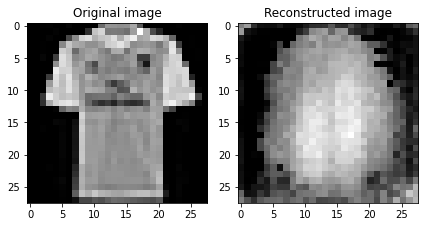

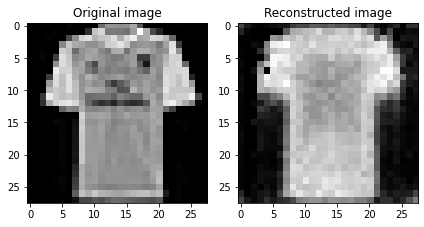

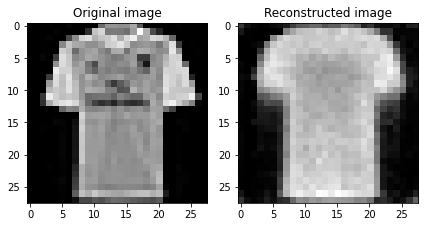

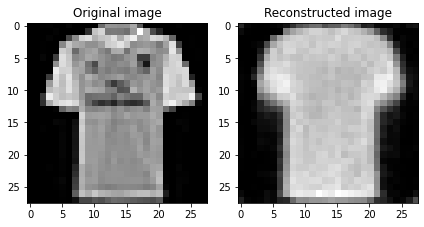

In [ ]:
#retrain best Autoencoder
best_encoder = Encoder(best_params)
best_decoder = Decoder(best_params)

best_encoder.to(device)
best_decoder.to(device)


train_loss, test_loss = training_and_validation(best_encoder, best_decoder,test_dataloader, best_params)


## 2.4) Performances


I decided to plot the trend of the reconstruction losses computed over the Training and Test sets, as well as some random examples of reconstructed images.

As we can see in the images below, the performaces of the Autoencoder are quite satisfying. The trend of the losses reflects the one of a correct learning process and the reconstructed pictures are most of the time a good approximation of the input images: according to the human perception they can correctly represent an existing object.



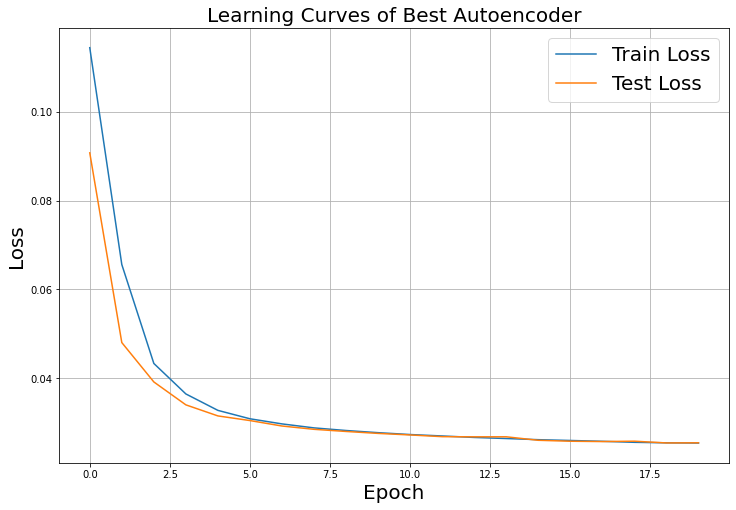

In [ ]:
#plot reconstruction loss trend
plt.figure(1,figsize=(12,8))
plt.plot(train_loss,label="Train Loss")
plt.plot(test_loss, label="Test Loss")
plt.xlabel("Epoch",fontsize=20)
plt.ylabel("Loss",fontsize=20)
plt.title("Learning Curves of Best Autoencoder",fontsize=20)
plt.legend(loc="best",fontsize=20)
plt.grid()
plt.show()

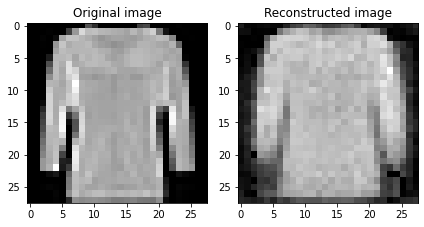

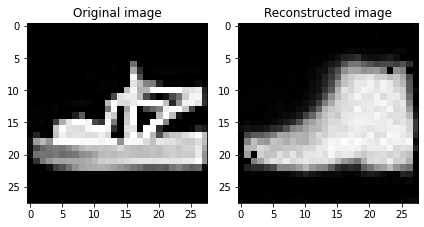

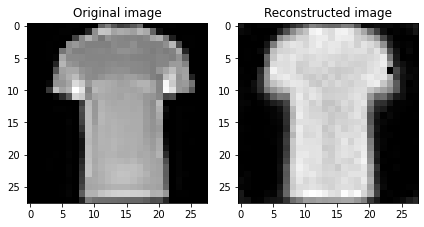

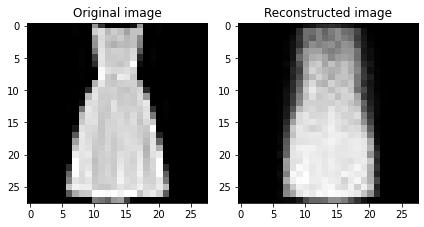

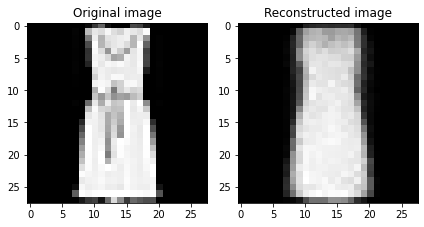

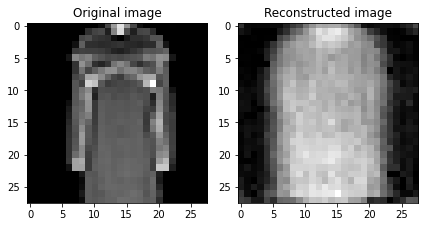

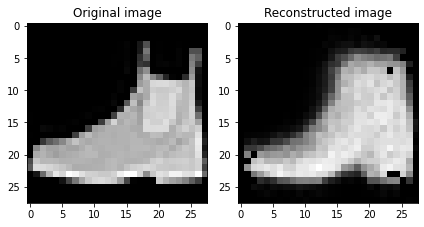

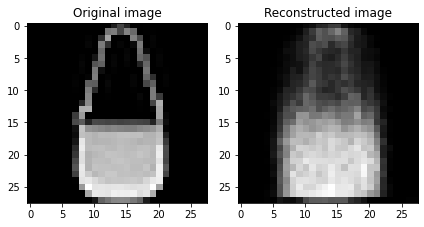

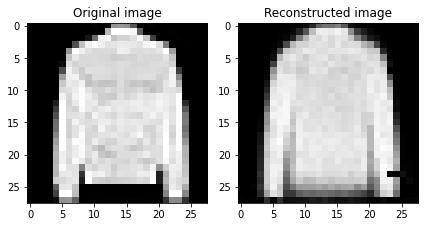

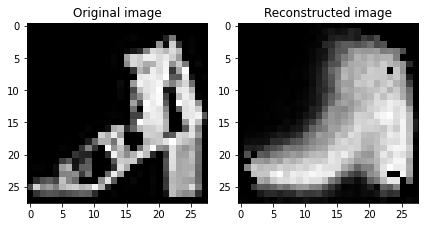

In [ ]:
for i in range(10):
  index = random.randint(0,len(test_dataset))
  plot_reconstruction(index,best_encoder,best_decoder,test_dataset)

In [ ]:
torch.save(best_encoder,'best_encoder.h5')
torch.save(best_decoder,'best_decoder.h5')
#best_encoder = torch.load('best_encoder.h5')
#best_decoder = torch.load('best_decoder.h5')

# 3) Explore Latent Space

### 3.1) Encoded representation of Test Samples

I explored the structure of the latent space as required from the homework description.

In order to do so, I had to map every image into its corresponding values in the latent space. I kept the best Encoder architecture as previously selected and I used it to prrocess every image in the Test Dataset.

The following cell takes each sample in the dataset and separates the images from their corresponding labels. Then it processes every input image throught the best Encoder architecture and stores the resulting output values, as well as the original label, into a dictionary.

The dictionary is eventually transformed into a pandas dataframe, in which each line has a one to one correspondance to each sample in the Test dataset and the reported values are the encoding of such image in the latent space.

In [ ]:
### Get the encoded representation of the test samples
encoded_samples = []

for sample in test_dataset:

    #divide data and label
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]

    #validation mode
    best_encoder.eval()
    
    #encode image latent space
    with torch.no_grad():
        encoded_img  = best_encoder(img)

    # Append dictionary to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)

# Convert to a dataframe
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples.head()


,Enc. Variable 0,Enc. Variable 1,Enc. Variable 2,label
0,9.215338,-15.897339,10.351433,9
1,-23.502914,15.559118,13.737239,2
2,13.412797,40.045780,-9.022695,1
3,14.686290,26.397955,-3.529492,1
4,-8.134854,6.327575,-0.051797,6


### 3.2) Principal Component Analysis

The Principal Component Analysis is a tool that we can use to visualize a higher dimensional space into a lower dimensional one.

The PCA studies the overall variation of each dimension of the higher space, it identifies the directions in which the highest variation  is present (therefore also the highest information) and it performs a change of basis along such directions. Eventually it projects each sample along the Principal Components directions, allowing the user to map and visualize a higher dimensional space intoa. lower one.

In order to do so on my set of data, I used the $\texttt{sklearn.decomposition.PCA}$ function. In the first line of the followong cell I defined the PCA engine as a mapping from a higher dimensional feature space into a 2 dimensional space.

The transformation is automatically performed by the $\texttt{.fit_transform}$ method, which takes as an argument the previously defined pandas dataframe.

I eventually plotted the results of the PCA into a 2D image, in order to visualize the distribution of the different classes into the feature space. The plotted variables $X_{1}$ and $X_{2}$ come from the projection performed by the PCA.

As we can see from the color code, similar classes tend to be represented as closer points in the latent space, even though the separation between each class is not always well defined. Some samples coming from different classes are indeed superimposed, partly due to the projection of the PCA algorithm and partly due to the imperfect identification of the samples. Object that are clearly different from a human point of view might still be interpreted as similar by the Autoencoder.



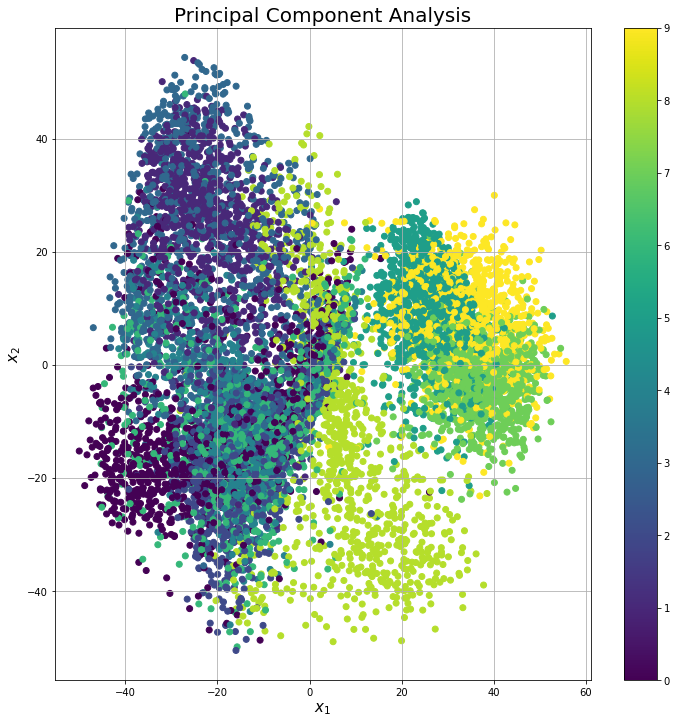

In [ ]:
#define PCA engine
pca = PCA(n_components=2)

#perform PCA from 3D to 2D space
encoded_samples_reduced_PCA = pca.fit_transform(encoded_samples)

#plot result of PCA
plt.figure(1,figsize=(12,12))
plt.title("Principal Component Analysis",fontsize=20)
plt.scatter(encoded_samples_reduced_PCA[:,0], encoded_samples_reduced_PCA[:,1], c=encoded_samples.label.to_numpy())
plt.xlabel("$x_{1}$",fontsize=15)
plt.ylabel("$x_{2}$",fontsize=15)
plt.colorbar()
plt.grid()
plt.show()

### 3.3) t-SNE

The Stochastic Neighbor Embedding is a different algorithm that allows us to project higher dimensional spaces into 2D spaces.

The philosophy behind it is the same as the PCA algorithm, but the Nighbor Embedding focuses on the distances between points rather than on the principal components dimensions.

The mapping from higher to lower dimensional spaces is done in a way that allows close points in the higher dimensional space to remain close in the lower dimensional one, as well as points that are far from eachother to remain afar. 

In this way a sort of clustering is performed and the final representation of samples makes us percieve in a better way the differences between the various classes.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


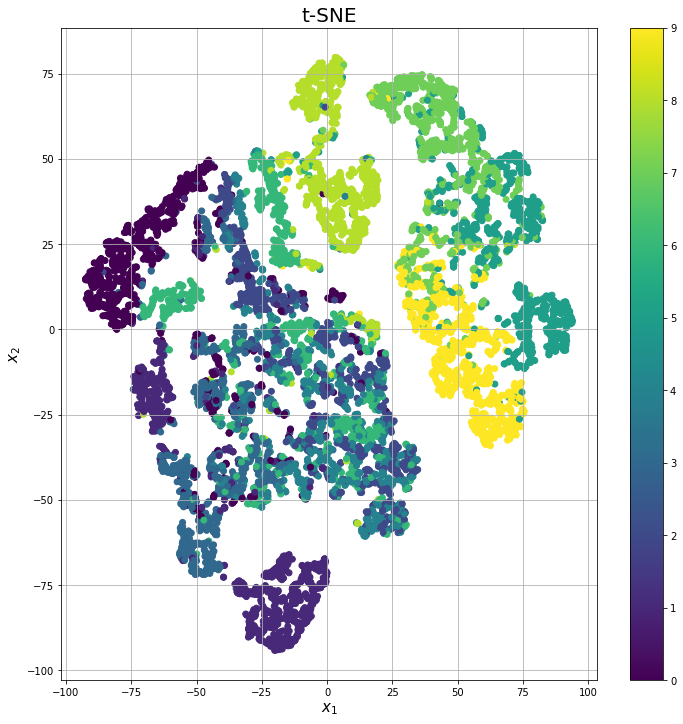

In [ ]:
#define TNSE engine
tsne = TSNE(n_components=2)

#perform TNSE
encoded_samples_reduced_TSNE = tsne.fit_transform(encoded_samples)

#plot result of TNSE
plt.figure(1,figsize=(12,12))
plt.title("t-SNE",fontsize=20)
plt.scatter(encoded_samples_reduced_TSNE[:,0], encoded_samples_reduced_TSNE[:,1], c=encoded_samples.label.to_numpy())
plt.xlabel("$x_{1}$",fontsize=15)
plt.ylabel("$x_{2}$",fontsize=15)
plt.colorbar()
plt.grid()
plt.show()

## 3.4) New samples generation from latent space

As a final check of the characteristics of the latent space, I produced a series of "fake" images by randomly selecting points in the feature space.

Since I have so far mapped images into values of the 3D latent space, I am now trying to do the opposite. In the following cell I am sampling random values of the three encoded variables from a uniform distribution defined over their previously studied range. 

Each combination of the three variables should be encoding an image, therefore I processed such values through the Decoder and plotted the output results.

Eventually what I retrieved is most of the time representing a reliable image. Some of the figures below can be easily recognized as trousers, bags, shirts and shoes; only some of them might come from a not-well-defined region in the latent space that might correspond to the encoding of multiple classes, therefore such objects are not alwaays recognizable.


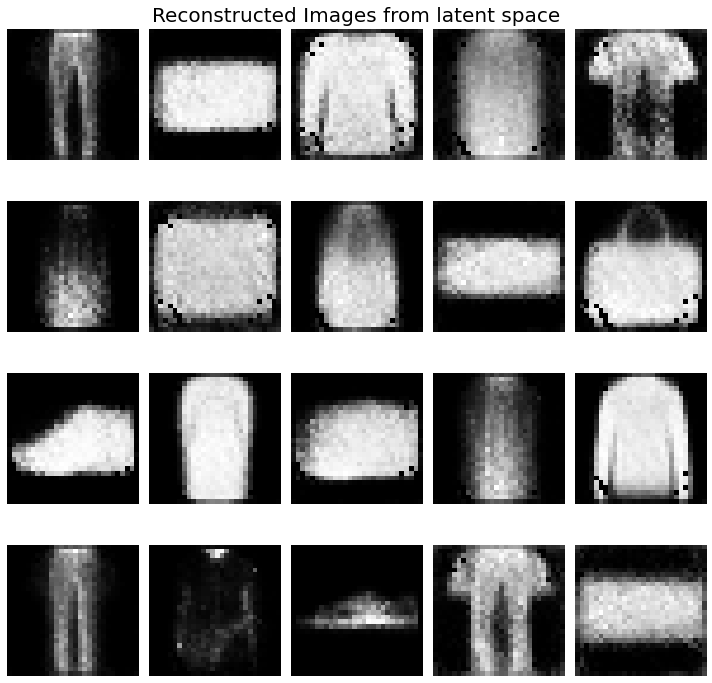

In [ ]:
# Generate random samples in latent space
fis, ax = plt.subplots(4,5,figsize=(10,10))

for i in range(4):
  for j in range(5):

    #select random values in enc varible's range
    val_var0 = np.random.uniform(min(encoded_samples['Enc. Variable 0']),max(encoded_samples['Enc. Variable 0']))
    val_var1 = np.random.uniform(min(encoded_samples['Enc. Variable 1']),max(encoded_samples['Enc. Variable 1']))
    val_var2 = np.random.uniform(min(encoded_samples['Enc. Variable 2']),max(encoded_samples['Enc. Variable 2']))
    
    #made-up sample in latent space
    custom_encoded_sample = [val_var0,val_var1,val_var2]
    encoded_value = torch.tensor(custom_encoded_sample).float().unsqueeze(0).to(device)

    # Decode sample
    best_decoder.eval()
    with torch.no_grad():
        reconstructed_img  = best_decoder(encoded_value)
        
    ax[i,j].imshow(reconstructed_img.squeeze().cpu().numpy(), cmap='gist_gray')
    ax[i,j].axis('off')
    

plt.suptitle("Reconstructed Images from latent space",fontsize=20)
plt.tight_layout()
plt.show()

#4) Fine-tuned Autoencoder

In the following section I will try maintain the knowledge learnt by the previously trained Encoder and to exploit it for a different task.
After the Encoder structure, I will add and train a new Classifier architecture. In this way the input images will firstly be encoded in the latent space, then they will be used to classify each sample into its correct label class.



### 4.1) Classifier Class and Training function

Here I define the new Classifier class. Its simple architecture is defined by three linear layers with variable number of neurons. The input values are always coming from the latent space, while the number of output neurons is fixed to the number of different classes, as the classification task requires. The number of hidden neurons are instead read from a parameter's dictionary and they are set by the user.


In [ ]:
class Classifier(nn.Module):
    
    def __init__(self, param_dict):
        super().__init__()

        #load classifier parameters
        lin_1 = param_dict['lin_1']
        lin_2 = param_dict['lin_2']
        lin_3 = param_dict['lin_3']
        encoded_latent_dim = param_dict['encoded_latent_dim']

        ### Linear section
        self.linear = nn.Sequential(
            nn.Linear(encoded_latent_dim, out_features=lin_1),nn.ReLU(True),
            nn.Linear(in_features=lin_1, out_features=lin_2),nn.ReLU(True),
            nn.Linear(in_features=lin_2, out_features=lin_3),nn.ReLU(True),
            nn.Linear(in_features=lin_3, out_features=10),nn.ReLU(True)
        )
        
    def forward(self, x):
        x = self.linear(x)
        return x

The training function for the fine-tuned Autoencoder has some slight differences with respect to the ones used before.

The main feature that needs to be understood is that the Encoder is always kept in validation mode, meaning that I will only be training the Classifier section of the architecture. In this way, I am keeping fixed the values of the Encoder's weights and updating only those of the Classifier.


The rest of the training function resembles the one used before in the notebook, even though now the loss function will change to $\texttt{nn.CrossEntropyLoss}$, since we are now evaluating the ability of the NN to classify each sample and not its reconstruction capacity.


In [ ]:
#fine tune training
def train_classifier(encoder,classifier,dataloader,param_dict):

    #load parameters from dict
    num_epochs = param_dict['num_epochs']
    loss_fn = param_dict['loss_fn']
    lr = param_dict['lr']
    weight_decay = param_dict['weight_decay']

    optim_model_param = [
    {'params': encoder.parameters()},
    {'params': classifier.parameters()}
    ]

    optimizer = getattr(optim, param_dict["optimizer"])(optim_model_param ,lr=lr, weight_decay=weight_decay)
        

    train_loss_log = []
    test_loss_log = []

    for epoch in range(num_epochs):

        #fixed encoder, trainable classifier
        encoder.eval()
        classifier.train()

        ###TRAINING
        train_loss = []
        for sample_batched in train_dataloader:
            
            x_batch = sample_batched[0].to(device)
            label_batch = sample_batched[1].to(device)
            
            encoded_data = encoder(x_batch)
            out = classifier(encoded_data)
            
            loss = loss_fn(out, label_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Save train loss for this batch
            loss_batch = loss.detach().cpu().numpy()
            train_loss.append(loss_batch)
        
        # Save average train loss
        train_loss = np.mean(train_loss)

        #both in eval mode
        encoder.eval()
        classifier.eval()

        ###VALIDATION
        val_loss = []
        with torch.no_grad(): 

            for sample_batched in dataloader:
                x_batch = sample_batched[0].to(device)
                label_batch = sample_batched[1].to(device)

                encoded_data = encoder(x_batch)
                out = classifier(encoded_data)
                
                loss = loss_fn(out, label_batch)
                loss_batch = loss.detach().cpu().numpy()
                val_loss.append(loss_batch)
                        
            #Save average validation loss
            val_loss = np.mean(val_loss)

        #store loss data
        train_loss_log.append(train_loss)
        test_loss_log.append(val_loss)


    return [train_loss_log,test_loss_log]




I defined the Classifier object with the following set of parameters and I eventually moved it to the device, where all the necessary operations for the training will be performed.

| Encoded Space Dim | Linear 1 | Linear 2 | Linear 3 |
| --- | --- | --- | --- |
| 3 | 150 | 50 | 20 |

In [ ]:
classifier_params = {
    'lin_1' : 150,
    'lin_2' : 50,
    'lin_3' : 20,
    'encoded_latent_dim' : 3
}

#define encoder and classifier objects
encoder_classifier = Encoder(best_params)
classifier = Classifier(classifier_params)

#move to device
encoder_classifier.to(device)
classifier.to(device)


Classifier(
  (linear): Sequential(
    (0): Linear(in_features=3, out_features=150, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=150, out_features=50, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=50, out_features=20, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=20, out_features=10, bias=True)
    (7): ReLU(inplace=True)
  )
)

I trained the Fine-tuned Convolutional Autoencoder with the following set of parameters:

| Num Epochs | Optimizer | Learning Rate | Weight Decay |
| --- | --- | --- | --- |
| 100 | Adam | $10^{-4}$ | $10^{-3}$ |

In [ ]:
#Fit
param_dict = {
    'num_epochs': 100,
    'loss_fn': nn.CrossEntropyLoss(), 
    'optimizer': 'Adam',
    'lr':  1e-4,
    'weight_decay': 1e-3
}

#Classifier training
ft_train_loss, ft_test_loss = train_classifier(encoder_classifier, classifier, val_dataloader, param_dict)

torch.cuda.empty_cache()

## 4.2) Performances

After having trained and tested the fine-tuned autoencoder on the training and validation data, I reported the trend of its learning curves.

The result reflects my expectations, showing the features of a correct learning process.


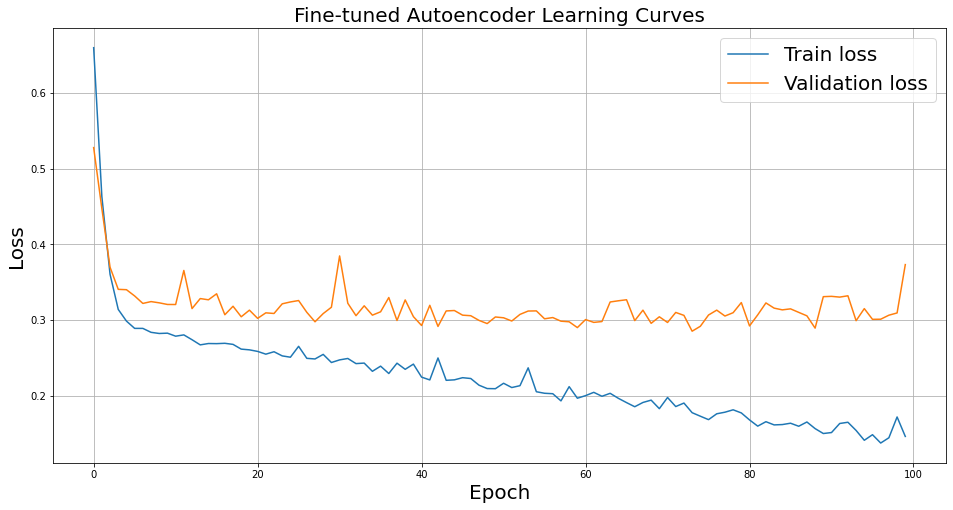

In [ ]:
# Plot losses
plt.figure(figsize=(16,8))
plt.plot(ft_train_loss, label='Train loss')
plt.plot(ft_test_loss, label='Validation loss')
plt.xlabel('Epoch',fontsize=20)
plt.ylabel('Loss',fontsize=20)
plt.title("Fine-tuned Autoencoder Learning Curves",fontsize=20)
plt.grid()
plt.legend(fontsize=20)
plt.show()

As in the previous notebook, I chose to compute the confusion matrix between the true labels of the Test set and the predicted ones.

In order to do so I have scanned the whole Test Dataloader and processed the samples through the newly defned Encoder and Classifier entities, both fixed in evaulation mode. I stored the values of the predicted labels in an empty list and I calculated the number of correct vs wrong classifications. Eventually I defined the accuracy as the ratio between the number of correctly classified samples and the number of total samples.

The **final accuracy** of this model is equal to **87%**. This result is compatible with the one retrieved in the Classification section of the last homework, even thought the performances this time appear to be slightly worse. This might be due to the fine tuning feature of the Autoencoder network: since the Encoder section has not been originally optimized for the classification task, its knowledge may be not enough focused on solving such a problem. Nonetheless the confusion matrix shows satisfying results, even though still reflecting a higher amount of errors when differentiating between t-shirt (label 0) and shirt (label 6) samples.


In [ ]:
#calculate predictions of fine tuned autoencoder
predictions = []
acc_log = []

preds_correct = 0
len_preds_correct = 0

#eval mode for both encoder and classifier
encoder_classifier.eval()
classifier.eval()

with torch.no_grad(): 

    for sample_batched in test_dataloader:

        #move data to device
        x_batch = sample_batched[0].to(device)
        label_batch = sample_batched[1].to(device)

        #process data through NN
        encoded_data = encoder_classifier(x_batch)
        out = classifier(encoded_data)
        
        #store prediction
        preds = torch.max(out,1)[1]
        predictions.append(preds.cpu().numpy())

        #count correct predictions
        preds_correct += torch.sum(preds==label_batch.data)
        len_preds_correct += len(label_batch)

    accuracy = preds_correct.detach().cpu().numpy()/len_preds_correct


#Accuracy of the model and confusion matri
print("Best Model accuracy: ", accuracy)

Best Model accuracy:  0.8729


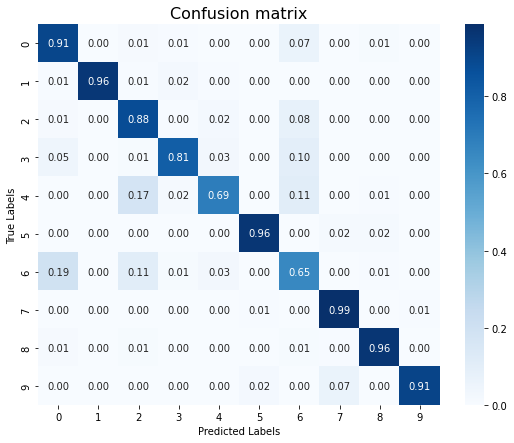

In [ ]:
#predicted vs true labels
y_pred = np.concatenate(predictions).ravel()
y_true = np.array([x[1] for x in test_dataset])

#built confusion matrix
matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize = (9,7))
sns.heatmap(matrix/1000, annot=True, fmt =  "1.2f", cmap='Blues'  )
plt.title('Confusion matrix', size=16)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

The below images report a random series of correctly and wrongly classified samples. It appears clearly that the confusion of the Neural Network about the classifications of t-shirts and shirts is completely justified.

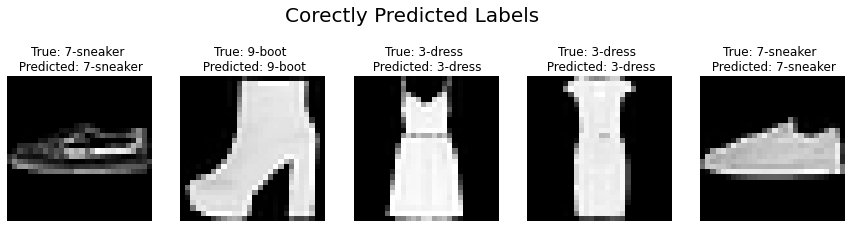

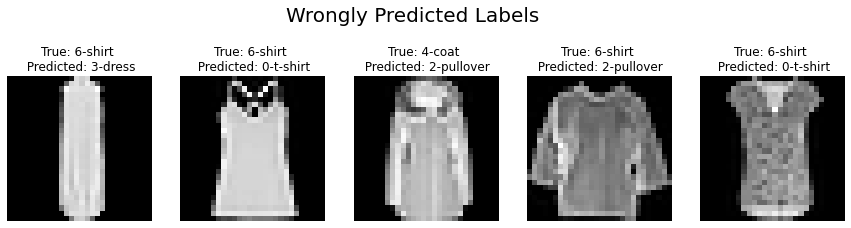

In [ ]:
label_names=['t-shirt','trouser','pullover','dress','coat','sandal','shirt',
             'sneaker','bag','boot']

right = np.where(y_pred == y_true)[0] 
right = np.random.choice(right,5)

error = np.where(y_pred != y_true)[0] 
error = np.random.choice(error,5)

plt.figure(1,figsize = (15,10))
for i,idx in enumerate(right):
    plt.subplot(1,5,i+1)
    plt.imshow(test_dataset[idx][0].numpy().transpose(1, 2, 0)[:,:,0], cmap='gray', interpolation='none')
    plt.title("True: {}-{} \n Predicted: {}-{}".format(test_dataset[idx][1],label_names[test_dataset[idx][1]],
                                                    y_pred[idx],label_names[y_pred[idx]]))
    plt.axis('off')
plt.suptitle("Corectly Predicted Labels", size=20,x=0.5,y=0.70)
plt.show()


plt.figure(2,figsize = (15,10))
for i,idx in enumerate(error):
    plt.subplot(1,5,i+1)
    plt.imshow(test_dataset[idx][0].numpy().transpose(1, 2, 0)[:,:,0], cmap='gray', interpolation='none')
    plt.title("True: {}-{} \n Predicted: {}-{}".format(test_dataset[idx][1],label_names[test_dataset[idx][1]],
                                                    y_pred[idx], label_names[y_pred[idx]]))
    plt.axis('off')

plt.suptitle("Wrongly Predicted Labels", size=20,x=0.5,y=0.70)
plt.show()

In [ ]:
torch.cuda.empty_cache()

# 5) Variational Autoencoder

The Variational Autoencoder comes in help when trying to fix the structure of the latent space. As we have seen before, the encoded space can be extremely irregular and even if points happen to be close in such a space they might not be representing similar objects.

The Variational Autoencoder allows us to enlarge the features of latent space, so that we can pass from a deterministic mapping of classes and points to a probabilistic description of the encoded informations.

##5.1) VAE classes

The $\texttt{VEncoder}$ class defined below has a similar structure with repect to the previous $\texttt{Encoder}$ class. The only difference now is that the output layers is only made by two neurons, representing the mean and the standard deviation of the distribution of the encoded informations in the latent space.

Here I report the architecture of the VEncoder entity:

| Input | Ch_conv1 | Ch_conv2 | Ch_conv3 | Output |
| --- | --- | --- | --- | --- |
| 1 | 8 | 16 | 32 | 2 |




In [41]:
class VEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        ### Convolutional section
        self.vencoder_cnn = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(in_channels = 1,  out_channels = 8, kernel_size = 4, 
                      stride = 2, padding = 1),
            nn.ReLU(True),
            # Second convolutional layer
            nn.Conv2d(in_channels =8,out_channels= 16, kernel_size= 3, 
                      stride=2, padding=1),
            nn.ReLU(True),
            # Third convolutional layer
            nn.Conv2d(in_channels=16, out_channels= 32, kernel_size=3, 
                      stride=2, padding=0),
            nn.ReLU(True)
        )
        
        self.flatten = nn.Flatten(start_dim=1)
        
        #mu and var
        self.mean    = nn.Linear(32*3*3, 2)
        self.std_dev = nn.Linear(32*3*3, 2)
        return
        
    def forward(self, x):
        x = self.vencoder_cnn(x)
        x = self.flatten(x)
        mean    = self.mean(x)
        std_dev = self.std_dev(x)
        
        return mean, std_dev

The VDecode entity is instead responsible of taking as inputs the mean and standard deviation values produced by the VEncoder and to transpose them into the shape of a newly generated image.

The VDecoder class presents 2 Linear layers and 3 Transposed Convolutional layers, with the following set of parameters:

| Input | Linear 1 | Linear 2 | Ch_Tconv3 | Ch_tconv2 | Ch_tconv1 | Output |
| --- | --- | --- | --- | --- | --- | --- |
| 2 | 64 | 288 | 32 | 16 | 8 | 1 |

As a last step, the sigmoid function is applied to the 28x28 output image in order to constrain the values in the range [0,1].

In [42]:
class VDecoder(nn.Module):
    
    def __init__(self):
        super().__init__()

        # Linear 
        self.var_lin = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(True),
            nn.Linear(64, 32*3 * 3),
            nn.ReLU(True)
        )

        # Unflatten
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))

        #Convolutional
        self.var_conv = nn.Sequential(
            nn.ConvTranspose2d(in_channels =32, out_channels=16, kernel_size=3, 
                               stride=2, output_padding=0),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=3, 
                               stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=8, out_channels=1, kernel_size=3, 
                               stride=2, padding=1, output_padding=1)
        )
        
    def forward(self, x):
        x = self.var_lin(x)
        x = self.unflatten(x)
        x = self.var_conv(x)
        x = torch.sigmoid(x)
        return x

The $\texttt{VariationalAutoencoder}$ class has been defined together with a series of method useful for its training and testing. To simply illustrate its functioning, I am gonna explain them step by step:

* $\texttt{__init__}$: The $\texttt{VEncoder}$ and $\texttt{VDecoder}$ objects are initialized as class attributes.

* $\texttt{forward}$: As usual, the forward method describes the overall functioning of the Deep Learning architecture. In this case, the mean and the standaard deviation are retrieved by the VEncoder output values and stored as class attributes. A random parameter $\texttt{eps}$ is drawn from a Normal Distribution $N(0,1)$ and stored as well as class attribute. Eventually the value sampled from the latent space distribution is processed through the VDecoder section.

* $\texttt{sampling}$: Since the image generation process from the VDecoder requires discrete values, a reparametrization of the encoded information is needed. The input values $\texttt{z}$ of the VDecoder are therefore redefined as follows: 
$z = \mu + \sigma*\epsilon$.

* $\texttt{train}$: The Train method scans the train dataloader batch per batch, computing separately the Reconstruction Loss as Mean Squared Error sum between the original vs reconstructed image values, and the Kullback–Leibler divergence between the Normal Distributiion $N(\mu,\sigma)$ and $N(0,1)$. The sum of this two loss values is used perform backpropagation and it is stored in a dedicated list.

* $\texttt{test}$: The test method evaluates the performances of the Autoencoder, computing the Global Loss over the samples taken by the Validaton Set.


* $\texttt{fit}$: Finally the Fit method allows me to iterate the above procedures over all the different epochs. I inserted the possibility to print and compare the reconstructed and original images every 5 epochs, in order to keep track of the performance of the algorithm.


In [43]:
class VariationalAutoencoder(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.encoder  = VEncoder()
        self.decoder  = VDecoder()
        return
    
    def forward(self, x):
        #encode image and retrieve mean and var
        mean, std_dev = self.encoder(x)

        #store mean,var and eps
        self.mu       = mean
        self.std_dev  = std_dev
        self.eps      = torch.norm(torch.tensor([0.,0.]),1)

        #sample from gaussian and decode information
        sample     = self.sampling()
        out        = self.decoder(sample)
        return out
    
        #reparametrization of normal dist z=mu(x)+eps*var(x)
    def sampling(self):
        sample = self.mu + self.std_dev*self.eps
        return sample 
    
    def train_(self, dataloader, optimizer):

        train_loss = []
        self.train()
        
        for image_batch, _ in dataloader: 

            #move data to device
            image_batch = image_batch.to(device)
            out = self.forward(image_batch)

            #compute reconstruction loss and KL divergence
            rec_loss = F.mse_loss(out, image_batch, reduction='sum')
            kl_loss = -0.5*torch.sum( 1 + self.std_dev - self.mu**2 - self.eps**2 )
            loss = rec_loss + torch.absolute(kl_loss)
    
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        # Save train loss for this batch
        loss_batch = loss.detach().cpu().numpy()
        train_loss.append(loss_batch)
        
        return np.mean(train_loss)
    
    def test_(self, dataloader):

        test_loss = []
        s_loss =[]
        self.eval()

        with torch.no_grad(): 
            conc_out = []
            conc_original = []

            for image_batch, _ in dataloader:
                #move data to device
                image_batch = image_batch.to(device)
                out = self.forward(image_batch)
             
                #append results
                conc_out.append(out.cpu())
                conc_original.append(image_batch.cpu())
            
            #move to tensor format
            conc_out = torch.cat(conc_out)
            conc_original = torch.cat(conc_original) 
            
            #Evaluate global loss
            test_loss = F.mse_loss(conc_out, conc_original)

        return test_loss.data

    
    def fit(self, train_dataloader, test_dataloader, optimizer, n_epochs = 40):
        
        train_loss_log = []
        test_loss_log   = []
        s_loss_log = []
        
        for epoch in range(n_epochs):

            #compute train and test loss per epoch
            train_loss = self.train_(train_dataloader, optimizer)
            test_loss = self.test_(test_dataloader)
            
            #store values in list
            train_loss_log.append(train_loss)
            test_loss_log.append(test_loss)
            
            # Plot the reconstructed image
            if epoch%5==0:
              img = test_dataset[0][0].unsqueeze(0).to(device)
          
              self.eval()
              with torch.no_grad():
                  rec_img  = self.forward(img)

              fig, axs = plt.subplots(1, 2, figsize=(8,4))
              axs[0].imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
              axs[0].set_title('Original image')
              axs[1].imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
              axs[1].set_title('Reconstructed image (EPOCH %d)' % (epoch))
              plt.tight_layout()
              plt.show()
                    
        return train_loss_log, test_loss_log
    

As we can see from the imagees below, at epoch 0 the algorithm is not capable yet to reproduce a believable image but after some iterations we manage to recognize the shape of the original object. Nonetheless, at some point the performance reache a maximum level and the algorithm stops improving its reconstruction abilities.

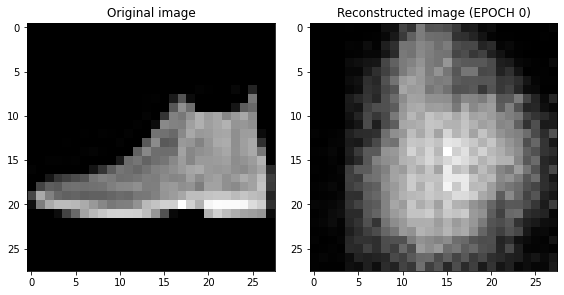

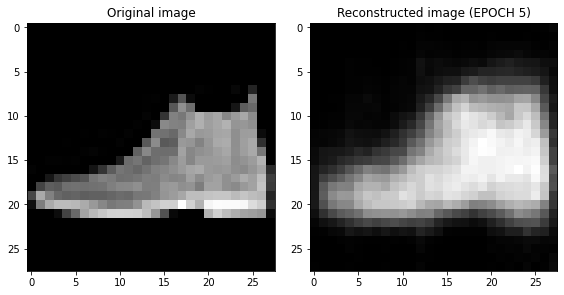

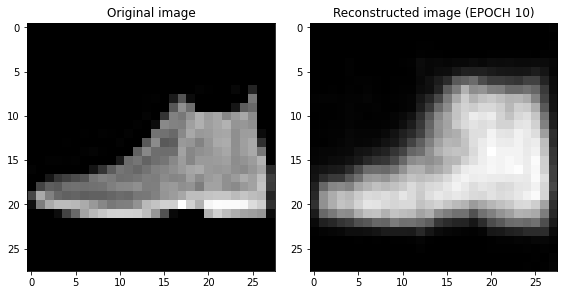

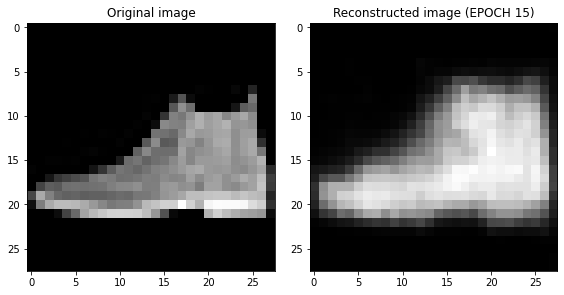

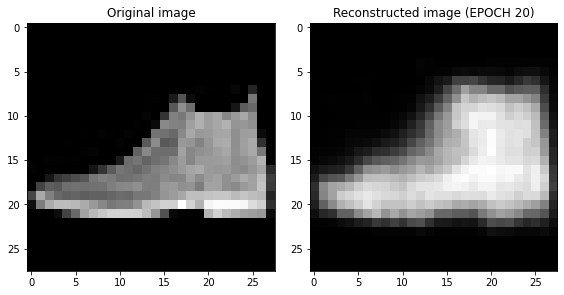

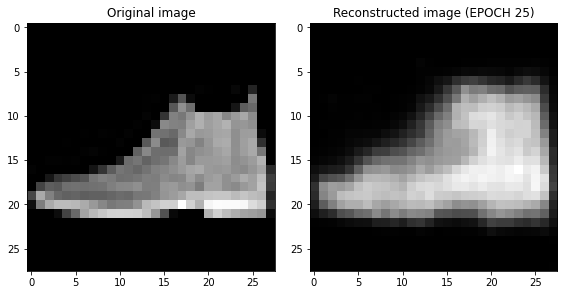

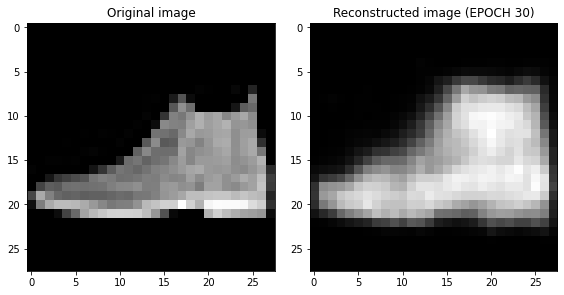

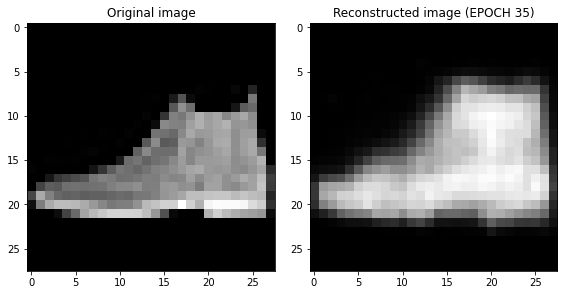

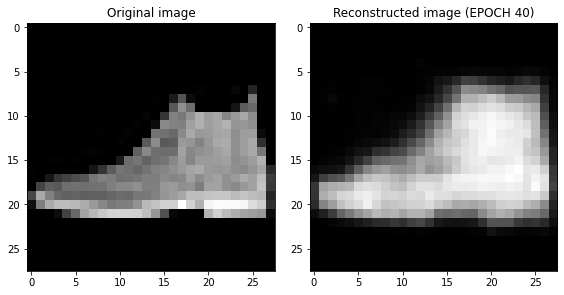

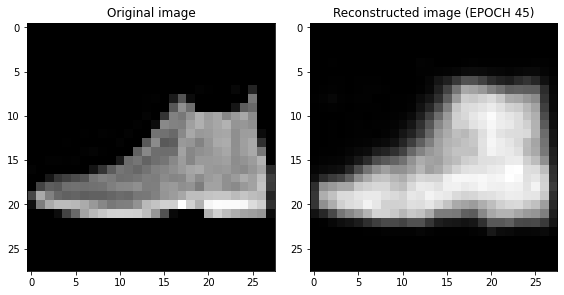

In [57]:
#define VAE and move to device
vae = VariationalAutoencoder()
vae.to(device)

#redefine dataloader objects for optimization
train_dataloader = DataLoader(train_dataset, batch_size=1000, shuffle=True,num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=1000, shuffle=True,num_workers=2)

optim = torch.optim.Adam(vae.parameters(), lr = 5e-3, weight_decay = 1e-5)
 
train_loss, test_loss = vae.fit(train_dataloader, test_dataloader, optim, 50)

##5.2) Learning curves and reconstructed images

Here I reported the trend of the Training an Test losses of the Variational Autoencoder. As you can see they represent a coherent learning process, nonetheless it must be noticed that the reported scales on the y axes present a quite different order of magnitude. This is due to the fact that the training loss is calculated as a sum of two contributions: Reconstruction + KL Loss. The test loss instead is just coomputed as the global capability of the Autoencoder to correctly generate a believable image in output, therefore the only contribution comes from the Reconstruction loss.

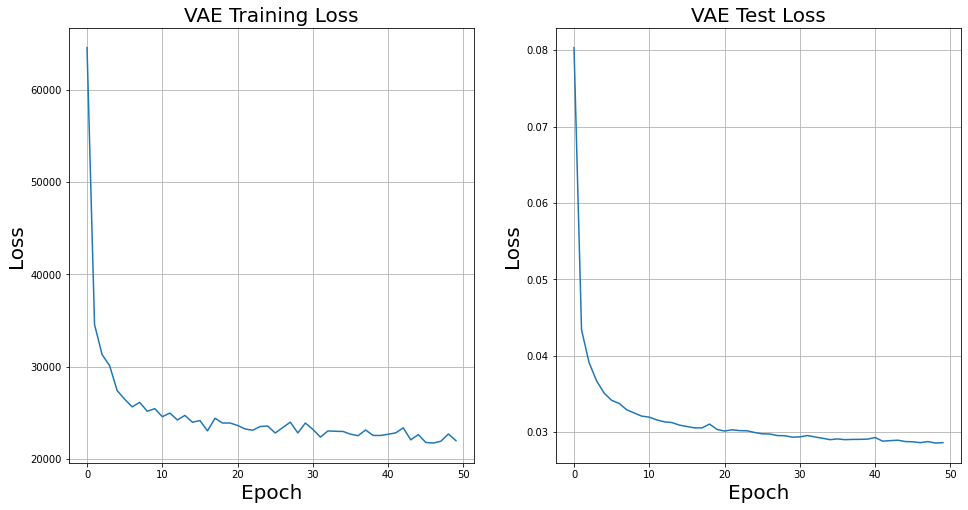

In [58]:
fig, ax = plt.subplots(1,2 ,figsize=(16,8))

ax[0].plot(np.array(train_loss))
ax[0].set_title("VAE Training Loss",fontsize=20)
ax[0].set_xlabel('Epoch',fontsize=20)
ax[0].set_ylabel('Loss',fontsize=20)
ax[0].grid()

ax[1].plot(np.array(test_loss))
ax[1].set_title("VAE Test Loss",fontsize=20)
ax[1].set_xlabel('Epoch',fontsize=20)
ax[1].set_ylabel('Loss',fontsize=20)
ax[1].grid()
plt.show()

I eventually plotted several recontructed images by scanning a region of the latent space. In this way we can see that the continuous transition of the encoded informations reflect a continuous transition in the representation of the images. The reconstructed objects are generally recognizable, even though of course some values in the latent space might refer to a "mixture" of two differrent classes, corresponding to a non-clear decoded image.

In [59]:
def plot_reconstructed(vae, r0, r1, shape=20):
    dim = 28
    img = np.zeros((shape*dim, shape*dim)) #big matrix image
    for i, y in enumerate(np.linspace(*r1, shape)):
        for j, x in enumerate(np.linspace(*r0, shape)):
            #decode (x,y)=z variables
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = vae.decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            #map small im age into big image
            img[(shape-1-i)*dim:(shape-1-i+1)*dim, j*dim:(j+1)*dim] = x_hat

    plt.figure(figsize=(15,15))
    plt.imshow(img, extent=[*r0, *r1], cmap = 'gist_gray')
    plt.show

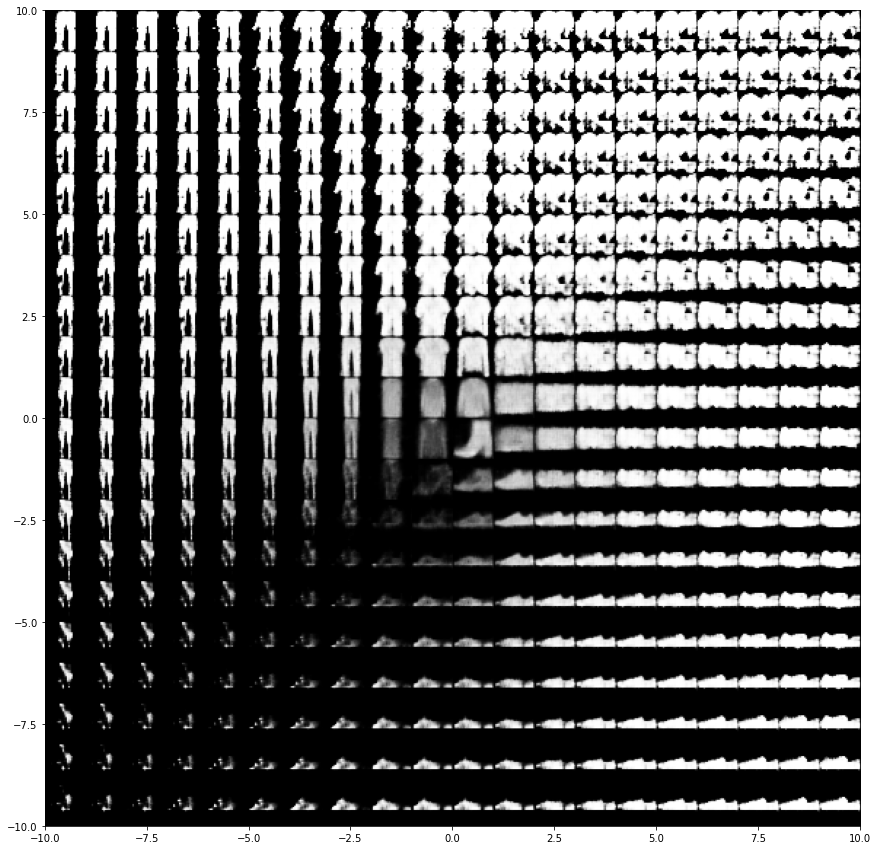

In [60]:
plot_reconstructed(vae, r0=(-10,10), r1=(-10,10)) #tune different ranges